In [112]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [196]:
import pandas as pd
import numpy as np
import json
import copy
import traceback

import matplotlib as mpl
from matplotlib import pyplot as plt

In [114]:
from log_parser import process_file


### parameters

In [137]:
# _fname = "../replays/local.log"
_fname = "../replays/log7.log"
_time_step = 100
_max_time = 200000
_symbols = ["PEARLS", "BANANAS"]
_products = ["PEARLS", "BANANAS"]


### pre processing

In [138]:
# load data from file

obj = process_file(_fname)
df = pd.DataFrame(obj)

listings = pd.DataFrame(df["listings"][0])
# products = set(listings.T["product"])
df = df.drop("listings", axis=1)
df = df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(df["time"])
print("num missing_times", len(missing_times))
print("missing_times", missing_times)


Reading from input file ../replays/log7.log
num missing_times 4
missing_times {79600, 78500, 152100, 120700}


In [139]:
# add turns (vs time)

all_times = df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
df["turn"] = df["time"].map(time2turn_map)

df.index = df["turn"]

In [140]:
def process_book(book):
    best_buy = {}
    best_sell = {}
    ret = {}
    cols = ["price", "quantity"]
    for sym in _symbols:
        orders = {
            "buy": pd.DataFrame(columns=cols),
            "sell": pd.DataFrame(columns=cols),
        }
        
        if sym in book:
            if "buy_orders" in book[sym]:
                orders["buy"] = pd.DataFrame(book[sym]["buy_orders"].items(), columns=cols).sort_values(by="price", ascending=False)
            if "sell_orders" in book[sym]:
                orders["sell"] = pd.DataFrame(book[sym]["sell_orders"].items(), columns=cols).sort_values(by="price", ascending=True)
        
        ret[sym] = orders
        
        if len(orders["buy"]) > 0:
            best_buy[sym] = orders["buy"]["price"][0]
        else:
            best_buy[sym] = np.nan
            
        if len(orders["sell"]) > 0:
            best_sell[sym] = orders["sell"]["price"][0]
        else:
            best_sell[sym] = np.nan
            
        
    return ret, best_buy, best_sell


books = pd.DataFrame(df["book"].apply(process_book).to_list(), columns=["book", "best_buy", "best_sell"])
book_tops = books.drop("book", axis=1)

# all book tops
book_tops = pd.concat([book_tops[c].apply(pd.Series).add_suffix(f"_{c}") for c in book_tops.columns], axis=1).astype(int)

for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)
book_tops["time"] = df["time"]

# all books
books = books["book"]

In [141]:
num_data = len(book_tops.dropna())
num_data_dropna = len(book_tops)

print(f"Orig count: {num_data}")
print(f"dropna count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 1996
dropna count: 1996
nan count: 0


In [142]:
def flatten_trades(df, col, is_me):
    # get market trades

    data = []
    for index, row  in df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_action"] = None
    df["my_action"] = np.where(df["buyer"] == "SUBMISSION", "buy", df["my_action"])
    df["my_action"] = np.where(df["seller"] == "SUBMISSION", "sell", df["my_action"])
    df["my_quantity"] = df["quantity"] * df["is_me"].astype(int) * (2 * (df["my_action"] == "buy").astype(int) - 1)
    
    return df

In [143]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")


# filter market trades (only keep those where order_time = fill_time)
market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# filter my_trades (only keep those where fill_time = order_time + 100)
my_trades = my_trades[my_trades["time"] == my_trades["order_time"] + _time_step]


trade_df = pd.concat([market_trades, my_trades])
trade_df = trade_df.sort_values(by="time").reset_index(drop=True)
# trade_df = trade_df.drop(["order_time", "buyer", "seller"], axis=1)

my_trades = trade_df[trade_df["is_me"]]
market_trades = trade_df[~trade_df["is_me"]]

print("my_trades count", len(my_trades))
print("market_trades count", len(market_trades))


my_trades count 294
market_trades count 296


In [185]:
a = []
def change(a):
    a += [1]
change(a)
a

[1]

In [199]:
# get my_positions
my_positions = pd.DataFrame(list(df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0
        
my_positions[["time", "turn"]] = df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
fixed_pos_data = []
pos_data = []
cur_positions = { prod: 0 for prod in _products }
cur_positions["cash"] = 0
cur_time = turn2time_map[0]

def record_pos_data(cur_positions, cur_time, pos_data, fixed_pos_data):
    global my_positions
    
    cur_turn = time2turn_map[cur_time]
        
    # init fixed_positions for this turn
    fixed_positions = copy.deepcopy(cur_positions)
    for prod in _products:
        diff = my_positions[prod][len(pos_data)] - cur_positions[prod]
        fixed_positions[prod] += diff
        fixed_positions["cash"] += -1 * diff * book_tops[f"{prod}_mid"][cur_turn]
    
    # copy fixed pos
    fixed_pos_data += [fixed_positions]
    
    # copy orig pos
    pos_data += [copy.deepcopy(cur_positions)]
    
    
for index, row in my_trades.iterrows():
    row_time = row["time"]
    while cur_time < row["time"]:
        record_pos_data(cur_positions, cur_time, pos_data, fixed_pos_data)
        cur_time = turn2time_map[len(pos_data)]
        
    prod = listings[row["symbol"]]["product"]
    cur_positions["cash"] += -1 * row["price"] * row["my_quantity"]
    cur_positions[prod] += row["my_quantity"]

# add for remaining turns
while cur_time < max(turn2time_map.values()):
    record_pos_data(cur_positions, cur_time, pos_data, fixed_pos_data)
    cur_time = turn2time_map[len(pos_data)]

record_pos_data(cur_positions, cur_time, pos_data, fixed_pos_data)



# pos_df contains calculated position data (based on my_trades)
pos_df = pd.DataFrame(pos_data).sort_index(axis=1)

# add to my_positions
my_positions["cash"] = pos_df["cash"]
my_positions = my_positions.sort_index(axis=1)


try:
    for prod in ["cash", *_products]:
        bad_inds = my_positions.index[my_positions[prod] != pos_df[prod]]
        if len(bad_inds) > 0:
            print("true pos")
            display(my_positions.loc[bad_inds])
            print("calculated pos")
            display(pos_df.loc[bad_inds])
            assert False, f"Failed check for product: `{prod}`"
except AssertionError:
    traceback.print_exc()
    
    print("Using fixed_pos_df['cash']")
    fixed_pos_df = pd.DataFrame(fixed_pos_data).sort_index(axis=1)
    my_positions["cash"] = fixed_pos_df["cash"]

true pos


,BANANAS,PEARLS,cash,time,turn
795,19.0,20.0,-297669.0,79700,795
796,19.0,20.0,-297669.0,79800,796
797,20.0,20.0,-302569.0,79900,797
798,20.0,20.0,-302569.0,80000,798
799,20.0,20.0,-302569.0,80100,799
...,...,...,...,...,...
1991,0.0,0.0,-4184.0,199500,1991
1992,0.0,0.0,-4184.0,199600,1992
1993,0.0,0.0,-4184.0,199700,1993
1994,0.0,0.0,-4184.0,199800,1994


calculated pos


,BANANAS,PEARLS,cash
795,20,20,-297669.0
796,20,20,-297669.0
797,21,20,-302569.0
798,21,20,-302569.0
799,21,20,-302569.0
...,...,...,...
1991,1,0,-4184.0
1992,1,0,-4184.0
1993,1,0,-4184.0
1994,1,0,-4184.0


Using fixed_pos_df['cash']


Traceback (most recent call last):
  File "/var/folders/fv/6rc0c0r11hn6xpyhsr9z6rrc0000gn/T/ipykernel_52320/3667028333.py", line 73, in <module>
    assert False, f"Failed check for product: `{prod}`"
AssertionError: Failed check for product: `BANANAS`


### Data analysis/vis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

### todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

In [201]:
# estimate fairs
mid_cols = [col for col in book_tops.columns if "_mid" in col]
fairs = book_tops[["time", *mid_cols]]
fairs.columns = fairs.columns.str.strip('_mid')
fairs

,time,BANANAS,PEARLS
0,0,4895.5,10000.0
1,100,4894.0,9998.5
2,200,4895.5,9999.5
3,300,4896.0,9996.5
4,400,4896.0,9999.5
...,...,...,...
1991,199500,4908.5,9996.5
1992,199600,4908.5,10000.0
1993,199700,4907.5,9999.5
1994,199800,4908.0,9999.5


In [202]:
# estimate pnl
pnls = my_positions["cash"]

for prod in _products:
    pnls = pnls + my_positions[prod] * fairs[prod]
    
my_positions["pnl"] = pnls

In [203]:
# plot trades
def plot_trades_and_book(sym, smooth_alpha=0.1):
    
    plt_df = trade_df[trade_df["symbol"] == sym]

    my_buys = plt_df[plt_df["my_quantity"] > 0]
    my_sells = plt_df[plt_df["my_quantity"] < 0]
    their_trades = plt_df[plt_df["my_quantity"] == 0]
    
    
    
    def plot_trades(ax):
        ax.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
        ax.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
        ax.scatter(their_trades["time"], their_trades["price"], c="gray", s=10)
    

    bids = book_tops[f"{sym}_best_buy"]
    asks = book_tops[f"{sym}_best_sell"]
    smooth_bids = bids.ewm(alpha=smooth_alpha).mean()
    smooth_asks = asks.ewm(alpha=smooth_alpha).mean()
    
#     plt.figsize(5, 5)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    
    # plot book
    ax = axes[0]
    ax.plot(df["time"], bids, c="green", alpha=0.5, linewidth=0.5)
    ax.plot(df["time"], asks, c="red", alpha=0.5, linewidth=0.5)
    plot_trades(ax)
    ax.set_title(f"Trades and book: {sym}")
    
    ax = axes[1]
    ax.plot(df["time"], smooth_bids, c="green", alpha=0.5, linewidth=0.5)
    ax.plot(df["time"], smooth_asks, c="red", alpha=0.75, linewidth=0.5)
    ax.set_title(f"(smooth) Trades and book: {sym}")
    plot_trades(ax)

    plt.show()
    

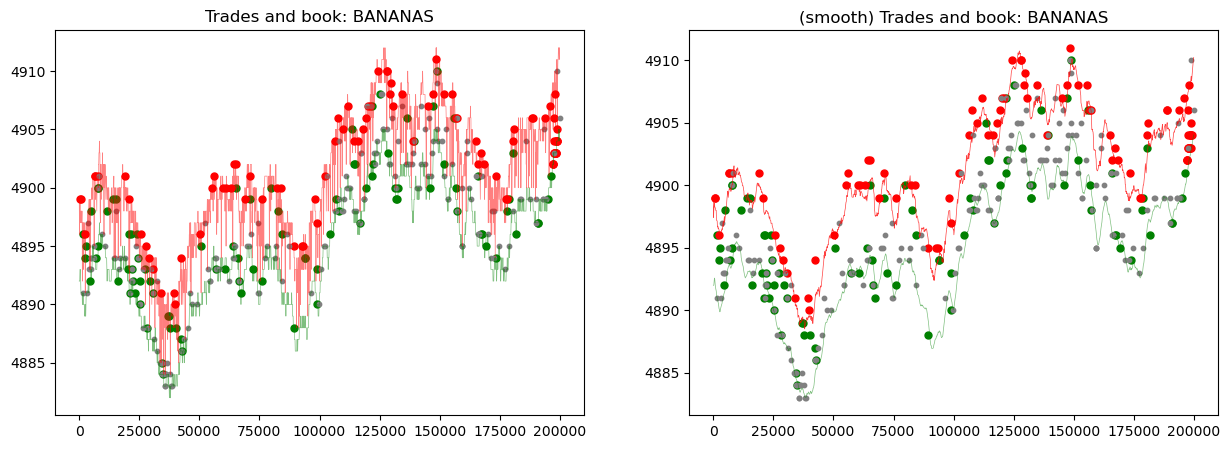

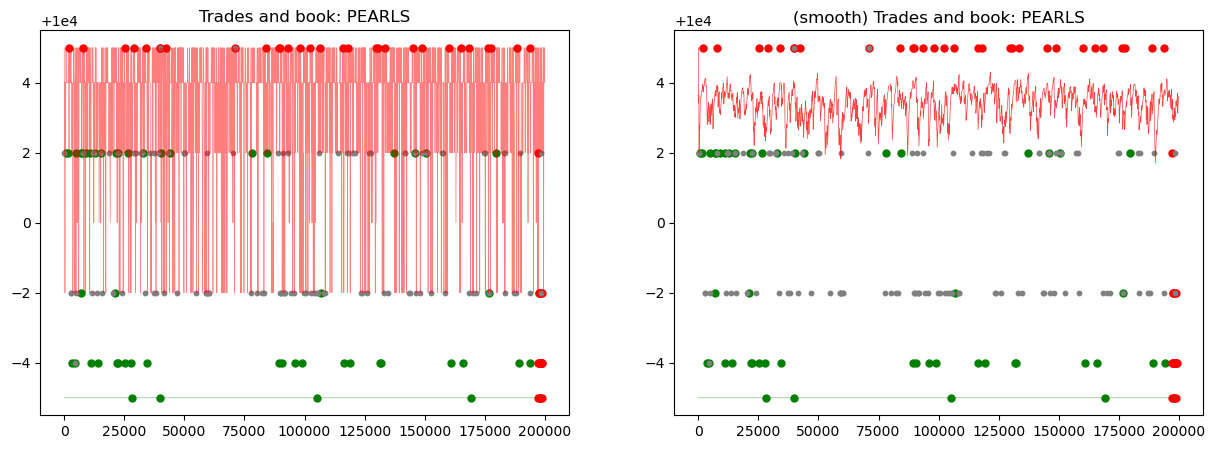

In [204]:
plot_trades_and_book(sym="BANANAS", smooth_alpha=0.1)
plot_trades_and_book(sym="PEARLS")

Text(0.5, 1.0, 'PNL')

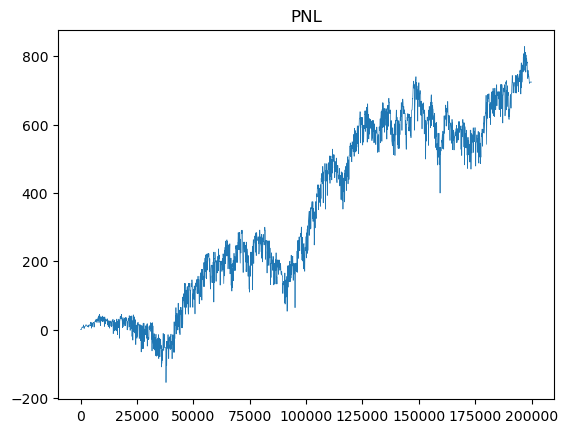

In [205]:
plt.plot(my_positions["time"], my_positions["pnl"], linewidth=0.5)
plt.title("PNL")

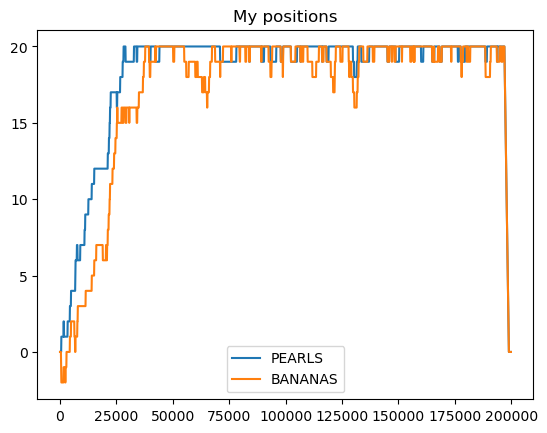

In [206]:
# plot my positions in each product

plt.plot(my_positions["time"], my_positions["PEARLS"], label="PEARLS")
plt.plot(my_positions["time"], my_positions["BANANAS"], label="BANANAS")
plt.title("My positions")
plt.legend()
plt.show()

In [207]:
col = book_tops[["BANANAS_mid", "PEARLS_mid"]]
diffs = (col.shift(-1) / col).dropna()
diffs.describe().T

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,1995.0,1.000001,0.000233,0.999182,0.999898,1.0,1.000102,1.000819
PEARLS_mid,1995.0,1.000000,0.000136,0.999650,0.999950,1.0,1.000050,1.000350
